In [24]:
from pathlib import Path
import cv2
import pandas as pd
!pip install tqdm
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [25]:
datasetPath = Path('dataset/self-built-masked-face-recognition-dataset')
maskPath = datasetPath/'AFDB_masked_face_dataset'
nonMaskPath = datasetPath/'AFDB_face_dataset'
maskDF = pd.DataFrame()
width = 224
height = 224
dim = (width, height)
maskDF=[]
Y=[]
for subject in tqdm(list(nonMaskPath.iterdir()), desc='non mask photos'):
    for imgPath in subject.iterdir():
        image = load_img(imgPath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        maskDF.append(image)
        label = "0"
        Y.append(label)
        


non mask photos: 100%|█████████████████████████████████████████████████████████████████| 26/26 [00:11<00:00,  2.17it/s]


In [26]:
len(Y)

5024

In [27]:
width = 224
height = 224
dim = (width, height)
for subject in tqdm(list(maskPath.iterdir()), desc='mask photos'):
    for imgPath in subject.iterdir():
        image = load_img(imgPath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        maskDF.append(image)
        label = "1"
        Y.append(label)

mask photos:  18%|████████████▏                                                      | 87/478 [00:00<00:03, 125.17it/s]


KeyboardInterrupt: 

In [ ]:
dfx1= maskDF[:1000]
dfx2=maskDF[-1000:]

In [ ]:
newMaskDF= [*dfx1, *dfx2]
newMaskDF = np.array(newMaskDF, dtype="float32")

In [ ]:
dfy1= Y[:1000]
dfy2=Y[-1000:]

In [ ]:
Y_label=[*dfy1, *dfy2]
Y_label = np.array(Y_label)

In [ ]:
len(Y_label)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(Y_label)
labels = to_categorical(labels)
import tensorflow as tf
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
#tf.convert_to_tensor(labels)
(trainX, testX, trainY, testY) = train_test_split(newMaskDF, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [17]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	trainX, trainY, batch_size=BS,
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
50/50 [==============================] - 40s 810ms/step - loss: 0.4844 - accuracy: 0.7794 - val_loss: 0.1157 - val_accuracy: 0.9792
Epoch 2/20
50/50 [==============================] - 40s 796ms/step - loss: 0.1201 - accuracy: 0.9638 - val_loss: 0.0639 - val_accuracy: 0.9870
Epoch 3/20
50/50 [==============================] - 41s 816ms/step - loss: 0.0764 - accuracy: 0.9775 - val_loss: 0.0483 - val_accuracy: 0.9896
Epoch 4/20
50/50 [==============================] - 41s 818ms/step - loss: 0.0559 - accuracy: 0.9850 - val_loss: 0.0435 - val_accuracy: 0.9896
Epoch 5/20
50/50 [==============================] - 40s 807ms/step - loss: 0.0461 - accuracy: 0.9894 - val_loss: 0.0379 - val_accuracy: 0.9896
Epoch 6/20
50/50 [==============================] - 42s 833ms/step - loss: 0.0353 - accuracy: 0.9906 - val_loss: 0.0355 - val_accuracy: 0.9896
Epoch 7/20
50/50 [==============================] - 42s 832ms/step - loss: 0.0299 - accuracy

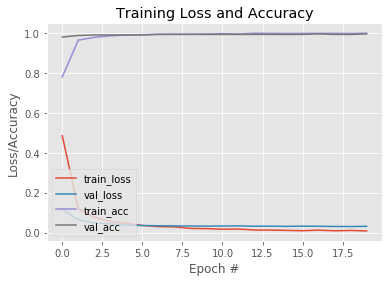

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [21]:
model.save_weights("model.h5")

In [23]:
model.save("mask_detection.h5")